In [6]:
# Import necessary libraries for text data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import nltk
nltk.data.path.append('/path/to/your/nltk_data')  # adjust this path
from nltk.corpus import stopwords
stopwords.words('english') # Common stopwords

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from wordcloud import WordCloud


import spacy
nlp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from nltk.corpus import stopwords
# Do#wnloading necessary resources for NLTK
nltk.data.path.append('/your/local/path/to/nltk_data')
from nltk.tokenize import word_tokenize,sent_tokenize# Tokenization tool
#nltk.download('punkt')  # Tokenization tool
#nltk.download('stopwords')  # Common stopwords

# Defining and refining the set of English stopwords
stop_words = set(stopwords.words('english'))
# Removing some stopwords that may carry important sentiment or meaning
stop_words = [i for i in stop_words if i not in ['not','until','against','up', 'down', 'no', 'nor',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
                                                 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "don't"]]



1. EXPLORATORY DATA ANALYSIS

1.1  DATA LOADING

In [2]:
# Reading a CSV file containing sentiment data, skipping bad lines
df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin',header=None,on_bad_lines='skip')
df.head()
# Renaming columns for better clarity
df.rename(columns={0: 'labels', 5: 'tweets'}, inplace=True)

# Dropping unnecessary columns from the DataFrame
df.drop([1, 2, 3, 4], axis=1, inplace=True)

# Replacing label 4 (positive sentiment) with 1 for uniformity
df['labels'] = df['labels'].replace(4, 1)

# Randomly shuffling the DataFrame and selecting a subset of 10,000 rows
df = df.sample(frac=1)
df = df.head(10000)

# Displaying the first few rows of the DataFrame
df.head()

,labels,tweets
184014,0,PUBLICLY want to retract my statement of dump...
1067460,1,@Vasilly Which is I guess not as many blogs as...
981929,1,watching gilmore girls
1544418,1,@galoera BBQ was amazing. Food was delisio! Wi...
1063276,1,@VonnieLovesSPN Cool! I wanna go read the con ...


1.2  DATA CLEANING

In [3]:
# Function to get the number of words in a tweet
def get_word_len(tweet):
    return len(tweet.split(' '))

# Function to get the number of characters in a tweet
def get_char_len(tweet):
    return len(tweet)

# Function to preprocess a tweet
def preprocess_tweet(tweet):
    # Convert the tweet to lowercase
    tweet = tweet.lower()
    
    # Remove URLs from the tweet
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions (e.g., @username) from the tweet
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove special characters and punctuation from the tweet
    tweet = re.sub(r'[^\w\s#]', '', tweet)
    
    # Lemmatize the words using spaCy
    tokens = [token.lemma_ for token in nlp(tweet)]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove single-character tokens
    tokens = [token for token in tokens if len(token) > 1]
    
    # Join the processed tokens to form the cleaned tweet
    processed_tweet = ' '.join(tokens)
    
    return processed_tweet

# Apply the preprocess_tweet function to each tweet in the dataframe
df['clean_tweets'] = [preprocess_tweet(tw) for tw in tqdm(df['tweets'], position=0, leave=True)]

# Calculate the number of words in each cleaned tweet and store it in a new column
df['tweet_words_length'] = df['clean_tweets'].apply(get_word_len)

# Calculate the number of characters in each cleaned tweet and store it in a new column
df['tweet_chars_length'] = df['clean_tweets'].apply(get_char_len)

# Display the first few rows of the dataframe
df.head()

100%|██████████| 10000/10000 [01:24<00:00, 117.75it/s]


,labels,tweets,clean_tweets,tweet_words_length,tweet_chars_length
184014,0,PUBLICLY want to retract my statement of dump...,publicly want retract statement dump twitter bf,7,47
1067460,1,@Vasilly Which is I guess not as many blogs as...,guess not many blog think comparatively,6,39
981929,1,watching gilmore girls,watch gilmore girl,3,18
1544418,1,@galoera BBQ was amazing. Food was delisio! Wi...,bbq amazing food delisio wine crisp dessert gr...,16,99
1063276,1,@VonnieLovesSPN Cool! I wanna go read the con ...,cool wanna go read con story lol thank,8,38


1.3   CREATING LABEL DISTRIBUTION

In [7]:
# Count the number of positive and negative tweets in the dataframe
positive_count = df[df['labels'] == 1].shape[0]
negative_count = df[df['labels'] == 0].shape[0]

# Create a pie chart using Plotly Express to visualize the distribution of positive and negative tweets
fig = px.pie(
    values=[positive_count, negative_count],  # Values represent the counts of positive and negative tweets
    title='Distribution of Positive and Negative Tweets',  # Title of the pie chart
    names=['Positive', 'Negative'],  # Labels for the two categories
    hover_name=['Positive', 'Negative'],  # Hover information for each category
    opacity=.9,  # Opacity of the pie chart
    template='simple_white'  # Plotly template for the chart
)

# Display the pie chart
fig.show()

1.4  CREATING WORD CLOUD

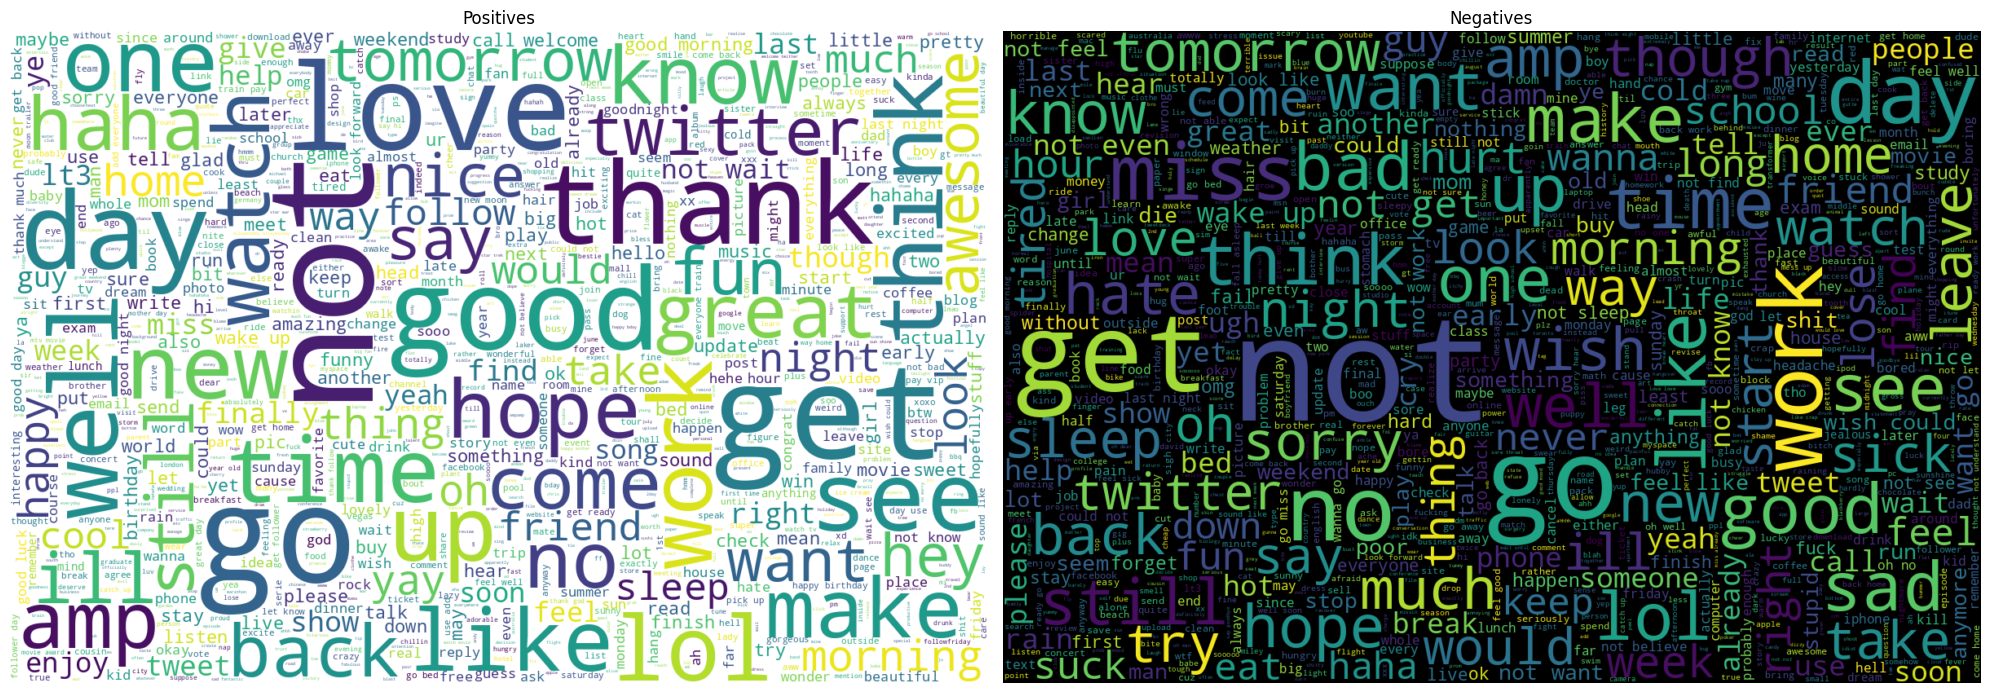

In [10]:
# Set up a figure with a specified size
plt.figure(figsize=(20, 8))

# Define stopwords for WordCloud (common words to exclude)
STOPWORDS = ['im','today','really','need','tonight']

# Plot two subplots side by side
plt.subplot(1, 2, 1)

# Generate and display a WordCloud for positive tweets
wordcloud_1 = WordCloud(
    width=1200, height=800, max_words=1000, contour_width=2,
    background_color='white', stopwords=STOPWORDS, max_font_size=180,
    colormap='viridis'
).generate(' '.join(df[df['labels'] == 1]['clean_tweets']))

plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title('Positives')

# Plot the second subplot
plt.subplot(1, 2, 2)

# Generate and display a WordCloud for negative tweets
wordcloud_2 = WordCloud(
    width=1200, height=800, max_words=1000, contour_width=2,
    background_color='black', stopwords=STOPWORDS, max_font_size=180,
    colormap='viridis'
).generate(' '.join(df[df['labels'] == 0]['clean_tweets']))

plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.title('Negatives')

# Turn off axis for the entire plot
plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

1.5  CREATING WORD LENGTH DISTRIBUTION

In [12]:
# Create distribution plots for word count and character count for positive and negative tweets
fig_words = ff.create_distplot(
    [df[df['labels'] == 1]['tweet_words_length'], df[df['labels'] == 0]['tweet_words_length']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

fig_chars = ff.create_distplot(
    [df[df['labels'] == 1]['tweet_chars_length'], df[df['labels'] == 0]['tweet_chars_length']],
    ['Positive', 'Negative'],
    bin_size=25,
    show_hist=False,
    show_rug=False
)

# Set titles and labels for the distribution plots
fig_chars.update_layout(title="Distribution Plot on Character Count", xaxis_title="Number of Characters", yaxis_title="Frequency")
fig_words.update_layout(title="Distribution Plot on Word Count", xaxis_title="Number of Words", yaxis_title="Frequency")

# Combine the plots in a 2-column layout
fig = make_subplots(rows=1, cols=2, subplot_titles=["Word Count", "Character Count"])
fig.add_trace(fig_words['data'][0], row=1, col=1)
fig.add_trace(fig_words['data'][1], row=1, col=1)
fig.add_trace(fig_chars['data'][0], row=1, col=2)
fig.add_trace(fig_chars['data'][1], row=1, col=2)

# Update overall layout and show the plot
fig.update_layout(title_text="Distribution Plots - Word Count vs Character Count", showlegend=True, font=dict(family="Arial", size=15, color="black"))
fig.show()